# Designing and simulating quantum circuits with cirq
In this tutorial we will learn the basics of using Google's quantum circuit designer, cirq.
To install cirq, please see the instructions at https://cirq.readthedocs.io/en/stable/install.html
1. What is cirq?
1. Making a circuit
    1. Quantum registers
    1. Operations and circuits
1. Simulating a circuit
    1. Simulating real quantum experiments
    1. Big-endian data
    1. Accessing wavefunctions
1. Parameterizing quantum circuits
    1. Declaring variables
    1. Fixing variables
    1. Fold functions
    1. Sweeping variables
1. Exercise - quantum teleportation

# What is cirq?

Cirq is a package to allow easy creation and editing of quantum circuits. Similar packages include IBM's QISKIT Terra, Rigetti's pyquil, Microsoft's Q#, and Xanadu's Strawberry Fields. All of these packages have methods to define and optimize a quantum circuit in terms of a primitive gate-set, and to store and manipulate output from a quantum device, and to feedback/optimize a quantum circuit in a hybrid quantum-classical scheme. Furthermore, most have some ability to simulate a quantum circuit classically (for up to a few tens of qubits), and to output quantum assembly language (qasm) code to send to a real device.

# Making a circuit
## Defining qubits
The first part of creating a quantum circuit is to define a set of qubits (also known as a quantum register), for operations (gates and measurement) to act upon. Each qubit requires a unique label for reference, in the same way that a classical variable needs a name, though this may be as simple as an index number.

Cirq has (currently) three different types of methods for labeling qubits - either by name (using the cirq.NamedQubit class), or by number in a linear array (using the cirq.LineQubit class) or a square lattice (using the cirq.GridQubit class). In this section we will create a circuit to make Bell pairs on two qubits, so LineQubits should be sufficient.

In [1]:
from cirq import LineQubit
qubits = [LineQubit(0), LineQubit(1)]
print(qubits)

[cirq.LineQubit(0), cirq.LineQubit(1)]


## Operations and circuits
To make a circuit, we need to add some operations. Operations are either measurements or gates --- a wide range of choices for the latter exist. When creating each operation, we need to specify which qubit(s) it acts upon.

We can make a Bell state preparation circuit with just a single Hadamard and CNOT gate, let's do it!

In [2]:
from cirq import H, CNOT, Circuit
circuit = Circuit()
circuit.append(H(qubits[0]))

# A CNOT gate requires both a control and a target qubit - in cirq, the control qubit is specified first.
circuit.append(CNOT(qubits[0],qubits[1]))
print(circuit)

0: ───H───@───
          │
1: ───────X───


Note that cirq prints out an ascii version of the quantum circuit instead of a list of the operations it contains. Internally, cirq divides the circuit into a set of Moments, which contain the operations that act in parallel in a single timestep. This may be further customized by the use of Schedules for implementation on real quantum devices, but we will not cover this in this course.

At the moment this circuit prepares a state, but does not measure it - this is the same as a function that doesn't return a final variable. Let's add a measurement to check the correlations of our prepared Bell state (in the Z basis).

In [3]:
from cirq import measure
# We label the measurement with a key for ease of future access
circuit.append(measure(*qubits, key='M'))  # Remember here writing *qubits is equivalent to qubits[0], qubits[1]
print(circuit)

0: ───H───@───M('M')───
          │   │
1: ───────X───M────────


# Simulating a circuit

For now (sadly) we will resort to simulating our quantum algorithms on a classical computer instead of a real quantum device. There are many different ways to simulate a quantum circuit, depending on what one is trying to optimize for (number of qubits, circuit depth, accuracy, noise modelling). Cirq currently has two simulators - a pure wavefunction simulator (cirq.Simulator), and a density-matrix simulator (cirq.DensityMatrixSimulator) that allows for accurate noise modeling --- with an increased computational cost. In this course, we will use the former, although the latter is important if one wants to test whether a quantum circuit is viable for NISQ-era devices.

A critical difference between classical simulation and actual implementation on a quantum device is whether we have access to the actual quantum state (which we do in most classical simulators), or just measurement results (which is all we have access to on a quantum device). Accessing the quantum state can useful for debugging or understanding the quantum algorithm being implemented. However, one must be careful, as using this data avoids many of the complexities of implementing quantum algorithms on real devices, and can lead to designing algorithms that are unfeasible in the real world.

In order to simulate a quantum algorithm as it would be done in the real world, we should use the cirq.Simulator.run command.

In [4]:
from cirq import Simulator
simulator = Simulator()
results = simulator.run(circuit, repetitions=100)
print(results.histogram(key='M'))

Counter({0: 51, 3: 49})


## Big-endian data
The result of the simulation is given in a sparse big-endian binary representation. That is, the nth binary digit of each key in the above histogram corresponds to the measurement result on the nth qubit. The associated value shows the number of times that this result was reported, but results that do not occur are not stored (to prevent having to store an exponentially-large number of 0's). Note that the sum of all values is equal to 100 --- the number of repetitions we chose for the circuit.

As our measurement is on 2 qubits, we have a total of $2^2=4$ possible outcomes:
* 0 := 00
* 1 := 01
* 2 := 10
* 3 := 11

The name 'big-endian' refers to the fact that the left-most bit of the string refers to the first qubit. The qubit order was declared when we added the measurement to the circuit.

The main result to observe from our Bell state is that the measurements are correlated - either both qubit 0 and qubit 1 measure 0 (final result = 0), or both qubit 0 and qubit 1 measure 1 (final result = 3 = 11). However, the measurement outcome of individual qubits in a Bell state is random, so we expect to see for each qubit 0 and 1 approximately 50 times each. Of course, as the result of each run is independently randomly drawn, don't expect to see 0 and 1 exactly 50 times each. The uncertainty in this, known as sampling noise, is a critical bottleneck in extracting information from a quantum computer that we will investigate later.

We'll come back to the Bell state in a bit, but let's go over the big-endian representation first to get comfortable with ordering.

**Exercise 1:** Create a circuit on two qubits in a linear array that flips qubit 0 and not qubit 1, and then measures them both.

What measurement outcome do you expect?

Simulate the circuit and see if the results match your expectations.

In [5]:
# You might find this gate useful.
from cirq import X
### Insert your code here!
circuit = Circuit()
circuit.append(X(qubits[0]))
circuit.append(measure(*qubits, key='M'))
print(circuit)
simulator.run(circuit, repetitions=10)

0: ───X───M('M')───
          │
1: ───────M────────


M=1111111111, 0000000000

**Exercise 2:** Adjust the ordering of the qubits in the measurement, re-simulate, and check that the results change as you expect.

In [6]:
### Insert your code here!
from cirq import X, SWAP
### Insert your code here!
circuit = Circuit()
circuit.append(X.on(qubits[0]))
print(circuit)
circuit.append(SWAP(qubits[0],qubits[1]))
print(circuit)
circuit.append(measure(*qubits, key='M'))
print(circuit)
simulator.run(circuit, repetitions=10)

0: ───X───
0: ───X───×───
          │
1: ───────×───
0: ───X───×───M('M')───
          │   │
1: ───────×───M────────


M=0000000000, 1111111111

In [7]:
### Insert your code here!
from cirq import X, SWAP
### Insert your code here!
circuit = Circuit()
circuit.append(X.on(qubits[0]))
print(circuit)
circuit.append(measure(*qubits, key='M', invert_mask=[True, True]))
print(circuit)
simulator.run(circuit, repetitions=10)

0: ───X───
0: ───X───!M('M')───
          │
1: ───────!M────────


M=0000000000, 1111111111

There is no need to treat the measurement on both qubits in a single operation. Indeed, for many algorithms it is critical that measurements be allowed at different points in the circuit, which will require different operations.

**Exercise 3:** Edit the above circuit for Bell state generation to use two separate measurement operations instead of one. You will need to use two different keys (try 'M0' and 'M1').

In [8]:
circuit = Circuit()
circuit.append(H(qubits[0]))
circuit.append(CNOT(qubits[0],qubits[1]))

###Replace this line!
circuit.append(measure(qubits[0], key='M0'))
circuit.append(measure(qubits[1], key='M1'))
print(circuit)

simulator = Simulator()
results = simulator.run(circuit, repetitions=100)
print()
print('Histogram of measurement on qubit 0')
print(results.histogram(key='M0'))
print()
print('Histogram of measurement on qubit 1')
print(results.histogram(key='M1'))

0: ───H───@───M('M0')───
          │
1: ───────X───M('M1')───

Histogram of measurement on qubit 0
Counter({1: 53, 0: 47})

Histogram of measurement on qubit 1
Counter({1: 53, 0: 47})


The above works, but the correlation information that characterise the Bell state is no longer present in the histogram, as we do not see whether each 0 in the first histogram corresponds to a 0 in the second. However, cirq does store this information. To recover it, we can use the Results.multi_measurement_histogram function.

In [9]:
print(results.multi_measurement_histogram(keys=['M0','M1']))

Counter({(1, 1): 53, (0, 0): 47})


This function has the advantage that the measurement outcome on each qubit is immediately visible, at the cost of a slight increase in the amount of code to be written. Which to use is entirely a matter of personal preference.

For data-processing purposes, we note that the elements of a Counter may be accessed in the same way as elements of a dictionary, or as single elements of an array. Unfortunately, slicing is **not** supported, but we will see soon how one may circumvent this issue. Also, elements that are not stored in a Counter (i.e. measurement outcomes that never occurred, and even those that cannot occur) may be called for --- the Counter will output 0 in such a case.

(For more information on Counters, see their entry in the Python docs --- https://docs.python.org/2/library/collections.html#collections.Counter )

In [10]:
hist = results.multi_measurement_histogram(keys=['M0','M1'])
print(hist[0,0])  # Accessing as array
print(hist[(0,0)])  # Accessing as tuple
print(hist[(0,1)])  # This result is never seen, but may still be queried.
print(hist[0,2])  # This result could never be seen (as M1 may only return a value of 0 or 1),
                  # but may still be safely queried.

47
47
0
0


## Accessing wavefunctions
Though the above circuit produces Bell states, we have not proven this, as we have only seen correlations along a single access --- this may be classically reproduced!

In a second we will adjust the above circuit to demonstrate this, but let us first check by directly accessing the wavefunction after running the circuit. This is achieved using the simulator.simulate command.

Recall that in the computational basis, the Bell state takes the form $$\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$$

In [11]:
circuit = Circuit()
circuit.append(H(qubits[0]))
circuit.append(CNOT(qubits[0],qubits[1]))
# Note that we do not add measurement 
result = simulator.simulate(circuit)
print(result.final_state.round(3))

[ 0.707+0.j  0.   +0.j -0.   +0.j  0.707+0.j]


# Parametrizing a quantum circuit
In order to prove that our Bell state is a Bell state without cheating, we need to perform measurement in multiple bases. This is a great time to investigate parametrized quantum circuits.

A parametrized quantum circuit is one where one or more gates have free variables to be specified at run-time. This allows for a classical script to treat the call to a quantum computer as a black box with free input variables, and, for instance, optimize over the output. This is a key idea in NISQ algorithms, which you will encounter next week in the lecture and tutorial.

## Declaring parameters

Parameters may be easily specified in cirq by the use of sympy's Symbol class - just replace angles that would be inserted by Symbol instances, and then fix values later in the code.

The gate that we are going to parameterize is a Y rotation on qubit 0
$$R_y(\theta) = e^{-i\theta/2 Y_0}=\left(\begin{array}{cc}\cos(\theta/2) & -\sin(\theta/2)\\ \sin(\theta/2) &\cos(\theta/2)\end{array} \right). $$
This rotates between the X and Z axis on qubit 0 as $\theta$ runs from $0\rightarrow\pi$, which means that at a measurement of the state $R_y(\theta)|\Psi\rangle$ in the Z (computational) basis is equivalent to a measurement of $|\Psi\rangle$ in the $\cos(\theta/2) Z - \sin(\theta/2) X$ basis. In most physical implementations of quantum devices, direct measurement along more than 1 axis is not possible, but the above is very cost-effective to implement.

Note that in the below, we have to make not one, but two calls to generate the rotation gate. The first call fixes the angle, whilst the second fixes which qubits the gate acts upon. Under the hood, this gate is decomposed into the native primitive gates used in Google's Xmon hardware.

(We will not have time to go into the details of hardware-specific circuit optimization. However, you should realise that this is a big feature of NISQ-era research --- textbook quantum algorithms are rarely executed as specified in real quantum hardware, and optimizing circuits for a given physical implementation can improve results by orders of magnitude or more.)

In [12]:
from sympy import Symbol
from cirq import ry
theta = Symbol('theta')

circuit = Circuit()
circuit.append(H(qubits[0]))
circuit.append(CNOT(qubits[0],qubits[1]))

# The parametrized magic
rotation = ry(theta)
circuit.append(rotation(qubits[0]))

circuit.append(measure(*qubits, key='M'))
print(circuit)

0: ───H───@───Ry(theta)───M('M')───
          │               │
1: ───────X───────────────M────────


## Fixing parameters

We cannot simulate the current circuit, as theta is undefined.

In [13]:
simulator.run(circuit, repetitions=100)

ValueError: Circuit contains ops whose symbols were not specified in parameter sweep. Ops: [cirq.ry(sympy.Symbol('theta')).on(cirq.LineQubit(0))]

The simplest way to specify the angle of the gate at runtime is to first use a cirq.ParamResolver, which generates a circuit we can simulate.

In [14]:
from cirq import ParamResolver, resolve_parameters
from numpy import pi
resolver = ParamResolver({'theta': pi/2})
resolved_circuit = resolve_parameters(circuit, resolver)
print(resolved_circuit)
result = simulator.run(resolved_circuit, repetitions=100)
print(result.histogram(key='M'))

0: ───H───@───Ry(0.5π)───M('M')───
          │              │
1: ───────X──────────────M────────
Counter({1: 31, 2: 24, 0: 23, 3: 22})


With theta set to $\pi/2$, we are measuring our Bell state in two uncorrelated bases, and we expect the results to be similarly uncorrelated.

To make a completely convincing proof, let us study the correlation between our measurements as we rotate $\theta$. This allows us to introduce two concepts - fold functions, and sweeps.

## Fold functions

A fold function is a function that takes measurement results from individual runs as input. Fold functions may be added as optional arguments to Result.histogram and Result.multi_measurement_histogram, in which case the output of the fold function is added to the histogram instead of the measurement output.

Fold functions must take as input one or many arrays of individual qubit measurements (depending on whether histogram or multi_measurement_histogram is used).

Let us write a fold function to measure the correlation between the output of qubit 0 and qubit 1.

In [15]:
def correlation_function(measurement):
    # The following returns 1 when measurement[0] == measurement[1]
    return 1 - measurement[0] ^ measurement[1]
print(result.histogram(key='M', fold_func=correlation_function))

Counter({0: 55, 1: 45})


## Sweeps

A sweep is simply an iteration over a set of parameters (in the same way that one would run a for loop in classical code). This may be implemented via cirq's Linspace class, which creates an equally spaced grid of parameter values for resolution in the simulator.run_sweep function.

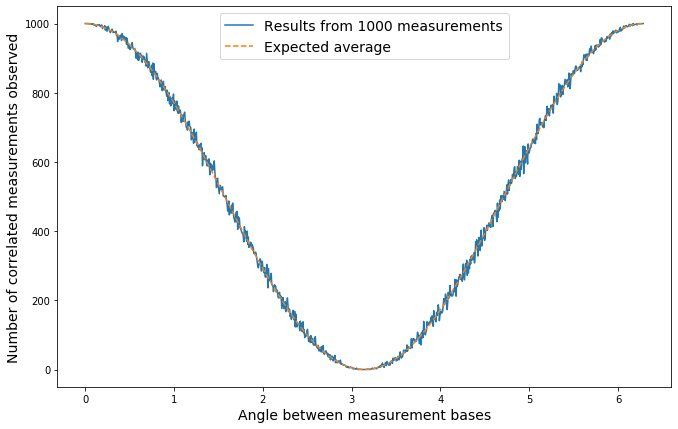

In [16]:
from cirq import Linspace
sweep = Linspace(key='theta', start=0, stop=2*pi, length=1000)
results = simulator.run_sweep(circuit, params=sweep, repetitions=1000)  # Note that we pass the unresolved circuit!

#Extract correlations using the fold function
correlations = [result.histogram(key='M', fold_func=correlation_function)[1] for result in results]

# Let's plot the results
from matplotlib import pyplot as plt
from numpy import linspace, cos
%matplotlib inline

plt.figure(figsize=(11,7))
x_values = linspace(0,2*pi,1000)
plt.plot(x_values, correlations, label='Results from 1000 measurements')
plt.xlabel('Angle between measurement bases', fontsize=14)
plt.ylabel('Number of correlated measurements observed', fontsize=14)
plt.plot(x_values, 500 * (cos(x_values) + 1), '--', label='Expected average')
plt.legend(fontsize=14)

We see that the resulting curve has quite some sampling noise, but it follows the expected value.

**Exercise 4:** extend the above experiment to demonstrate that if qubit 0 is rotated by $R_y(\theta_0)$ and qubit 1 is rotated by $R_y(\theta_1)$ prior to measurement, the correlation between measurements is independent of $\theta_0+\theta_1$.

In [17]:
from sympy import Symbol
from cirq import ry
thetas = [Symbol('theta0'), Symbol('theta1')]
circuit = Circuit()
circuit.append(H(qubits[0]))
circuit.append(CNOT(qubits[0],qubits[1]))

# The parametrized magic
rotation = ry(theta)
circuit.append(ry(thetas[0]).on(qubits[0]))
circuit.append(ry(thetas[1]).on(qubits[1]))

circuit.append(measure(*qubits, key='M'))
print(circuit)

0: ───H───@───Ry(theta0)───M('M')───
          │                │
1: ───────X───Ry(theta1)───M────────


In [18]:
from cirq import Linspace
sweep = (Linspace(key='theta0', start=0, stop=2*pi, length=100)* 
         Linspace(key='theta1', start=-1*pi, stop=1*pi, length=100))
results = simulator.run_sweep(circuit, params=sweep, repetitions=100)  # Note that we pass the unresolved circuit!

#Extract correlations using the fold function
correlations = [result.histogram(key='M', fold_func=correlation_function)[1] for result in results]

### Let's make a 2D plot

No handles with labels found to put in legend.


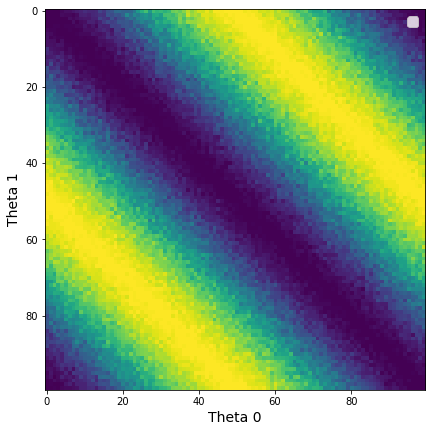

In [19]:
# Let's plot the results
from matplotlib import pyplot as plt
from numpy import linspace, cos
import numpy
%matplotlib inline

plt.figure(figsize=(11,7))
x_values = linspace(0,2*pi,100)
plt.imshow(numpy.array(correlations).reshape(100, 100), label='Results from 100 measurements')
plt.xlabel('Theta 0', fontsize=14)
plt.ylabel('Theta 1', fontsize=14)
plt.legend(fontsize=14)

# Quantum teleportation
One of the most famous quantum effects is that of teleportation, where the state from one qubit may be transmitted to the state of another qubit non-locally. Details of this may be found on Wikipedia, or in Nielsen and Chuang.

To begin, we need to prepare a Bell state on two qubits, and prepare a state to be teleported.

**Exercise 5:** Create a three-qubit circuit on a linear array that performs an arbitrary $R_y(\theta)$ rotation on qubit 0, and that prepares a Bell state on qubits 1 and 2.

In [47]:
qubits = [LineQubit(i) for i in range(3)]
theta = Symbol('theta')
circuit = Circuit()
circuit.append(ry(theta).on(qubits[0]))

circuit.append(H(qubits[1]))
circuit.append(CNOT(qubits[1],qubits[2]))

print(circuit)

0: ───Ry(theta)───────

1: ───H───────────@───
                  │
2: ───────────────X───


The teleportation circuit requires entangling qubit 0 and 1 via a CNOT gate, then reading qubit 0 in the X basis and qubit 1 in the Z basis.

**Exercise 6:** Add the above circuitry to your quantum circuit (this requires four operations total).

In [48]:
### Insert your code here!
circuit.append(CNOT(qubits[0], qubits[1]))
circuit.append(H(qubits[0]))
#circuit.append(measure(*qubits[0:2], key='M'))

print(circuit)

0: ───Ry(theta)───────@───H───
                      │
1: ───H───────────@───X───────
                  │
2: ───────────────X───────────


The final part of the teleportation circuit requires performing single qubit rotations on qubit 2, depending on the output of the two measurements. To implement this, we need to use controlled gates - gates that are implemented or not depending on the result of prior measurements. These are called using the Gate.controlled construction.

(Note that these gates are controlled by the post-measurement state of the qubits, and not the measurement result. In your circuit these should be the same, but be careful!)

In [49]:
from cirq import X, Z
controlledX = X.controlled(1)
controlledZ = Z.controlled(1)
circuit.append(controlledX(qubits[1],qubits[2]))
circuit.append(controlledZ(qubits[0],qubits[2]))
print(circuit)

0: ───Ry(theta)───────@───H───@───
                      │       │
1: ───H───────────@───X───@───┼───
                  │       │   │
2: ───────────────X───────X───@───


To test the teleportation, let us check the result of measuring qubit 2 in the Z basis as we change the prepared state by altering the angle $\theta$.

**Exercise 7:** Add a measurement of qubit 2 in the Z basis, and plot the result of these measurements as you sweep over $\theta$. (Note that you do not need to write a fold function to extract the histogram results.)

In [50]:
### Insert your code here!
circuit.append(measure(qubits[2], key='M2'))
print(circuit)

0: ───Ry(theta)───────@───H───@─────────────
                      │       │
1: ───H───────────@───X───@───┼─────────────
                  │       │   │
2: ───────────────X───────X───@───M('M2')───


In [61]:
sweep = Linspace(key='theta', start=0, stop=2*pi, length=100)
results = simulator.run_sweep(circuit, params=sweep, repetitions=1000)

In [62]:
count0 = []
count1 = []
for result in results:
    count0 += [result.histogram(key='M2')[0]]
    count1 += [result.histogram(key='M2')[1]]

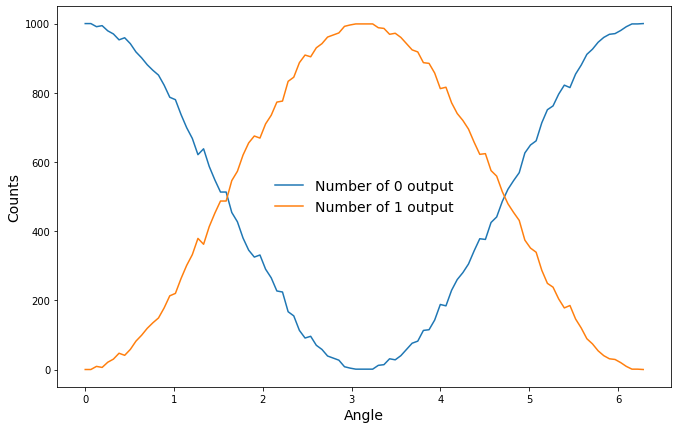

In [63]:
plt.figure(figsize=(11,7))
x_values = linspace(0,2*pi,100)
plt.plot(x_values, count0, label='Number of 0 output')
plt.plot(x_values, count1, label='Number of 1 output')
plt.xlabel('Angle', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(fontsize=14, frameon=False)